# Box versus Wheel - SSD-MobileNetV2
- by Marcelo Rovai @Set24

In [2]:
import tflite_runtime.interpreter as tflite
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import time

print("NumPy:", np.__version__)
print("Pillow:", Image.__version__)

NumPy: 1.24.2
Pillow: 11.3.0


In [3]:
ls models

coco_labels.txt                  ssd-mobilenet-v1-tflite-default-v1.tar.gz
ei-iesti05-obj-detect-int8.lite  ssd-mobilenet-v1-tflite-default-v1.tflite*


In [4]:
# Try to create a TFLite Interpreter
model_path = "./models/ei-iesti05-obj-detect-int8.lite"
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
print("TFLite Interpreter created successfully!")

TFLite Interpreter created successfully!


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [6]:
input_details

[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.int8,
  'quantization': (0.003921568859368563, -128),
  'quantization_parameters': {'scales': array([0.00392157], dtype=float32),
   'zero_points': array([-128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details

[{'name': 'StatefulPartitionedCall:1',
  'index': 378,
  'shape': array([ 1, 10], dtype=int32),
  'shape_signature': array([ 1, 10], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:3',
  'index': 376,
  'shape': array([ 1, 10,  4], dtype=int32),
  'shape_signature': array([ 1, 10,  4], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'StatefulPartitionedCall:0',
  'index': 379,
  'shape': array([1], dtype=int32),
  'shape_signature': array([1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32

In [8]:
ls ./images/

1_box.jpg          2-box.jpg    beatch.jpg     home-office.jpg  ship_2.jpg
2_box-1_wheel.jpg  2-wheel.jpg  cat_dog.jpeg   man_cat_dog.jpg
2_box_2_wheel.jpg  beagles.jpg  cats_dogs.jpg  office.jpeg


/usr/lib/python3/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/lib/python3/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


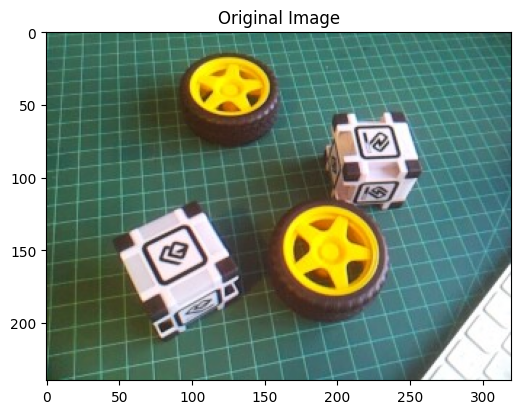

In [9]:
# Load he image
img_path = "./images/2_box_2_wheel.jpg"
orig_img = Image.open(img_path)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(orig_img)
plt.title("Original Image")
plt.show()

In [10]:
scale, zero_point = input_details[0]['quantization']
img = orig_img.resize((input_details[0]['shape'][1], 
                  input_details[0]['shape'][2]))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
input_data = np.expand_dims(img_array, axis=0)

In [11]:
input_data.shape, input_data.dtype

((1, 320, 320, 3), dtype('int8'))

In [12]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 642.1ms


In [13]:
interpreter.get_tensor(output_details[0]['index'])[0]

array([0.98046875, 0.9296875 , 0.78515625, 0.65625   , 0.5       ,
       0.5       , 0.5       , 0.34375   , 0.34375   , 0.21484375],
      dtype=float32)

In [14]:
interpreter.get_tensor(output_details[1]['index'])[0]

array([[0.04874735, 0.27987683, 0.33159006, 0.5206855 ],
       [0.47812793, 0.4757945 , 0.8224344 , 0.74386805],
       [0.4690769 , 0.14498271, 0.9017104 , 0.47131068],
       [0.22084655, 0.58959466, 0.51398474, 0.80591136],
       [0.07411633, 0.29450995, 0.2590304 , 0.49313062],
       [0.04590099, 0.55754244, 0.47555077, 0.8423493 ],
       [0.2532825 , 0.49617577, 0.6753199 , 0.79667366],
       [0.6168053 , 0.7574802 , 0.9736445 , 1.0026324 ],
       [0.69037783, 0.80053794, 0.9444535 , 0.9887873 ],
       [0.20044   , 0.313876  , 0.33355242, 0.5325757 ]], dtype=float32)

In [15]:
interpreter.get_tensor(output_details[2]['index'])[0]

10.0

In [16]:
interpreter.get_tensor(output_details[3]['index'])[0]

array([1., 1., 0., 0., 1., 0., 0., 1., 0., 1.], dtype=float32)

In [17]:
boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
classes = interpreter.get_tensor(output_details[3]['index'])[0]  
scores = interpreter.get_tensor(output_details[0]['index'])[0]        
num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])

In [18]:
# Post-process the results
for i in range(num_detections):
    if scores[i] > 0.5:  # Confidence threshold
        print(f"Object {i}:")
        print(f"  Bounding Box: {boxes[i]}")
        print(f"  Confidence: {scores[i]}")
        print(f"  Class: {classes[i]}")

Object 0:
  Bounding Box: [0.04874735 0.27987683 0.33159006 0.5206855 ]
  Confidence: 0.98046875
  Class: 1.0
Object 1:
  Bounding Box: [0.47812793 0.4757945  0.8224344  0.74386805]
  Confidence: 0.9296875
  Class: 1.0
Object 2:
  Bounding Box: [0.4690769  0.14498271 0.9017104  0.47131068]
  Confidence: 0.78515625
  Class: 0.0
Object 3:
  Bounding Box: [0.22084655 0.58959466 0.51398474 0.80591136]
  Confidence: 0.65625
  Class: 0.0


In [19]:
# Define labels 
labels = ['box', 'wheel'] 

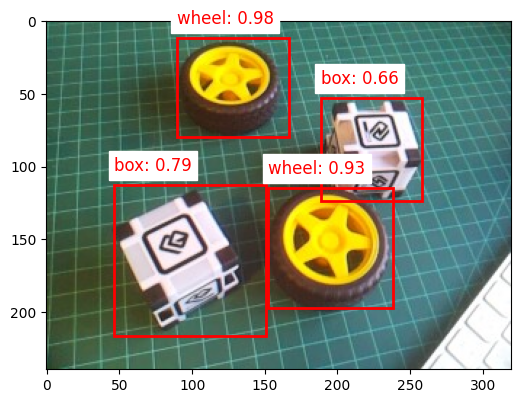

In [20]:
# Visualize the results
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
for i in range(num_detections):
    if scores[i] > 0.5:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

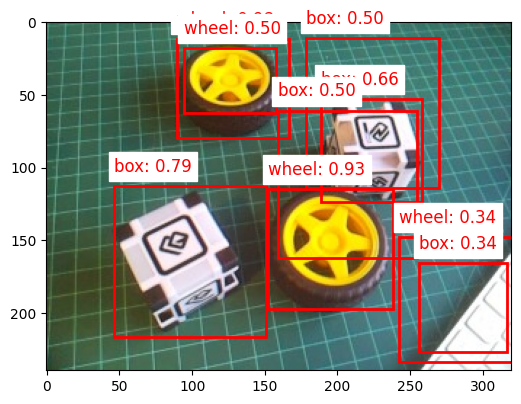

In [21]:
# Visualize the results
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
for i in range(num_detections):
    if scores[i] > 0.3:  # Adjust threshold as needed
        ymin, xmin, ymax, xmax = boxes[i]
        (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                      ymin * orig_img.height, ymax * orig_img.height)
        rect = plt.Rectangle((left, top), right-left, bottom-top, 
                             fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
        class_id = int(classes[i])
        class_name = labels[class_id]
        plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                 color='red', fontsize=12, backgroundcolor='white')

In [22]:
def detect_objects(img_path, conf=0.5):
    orig_img = Image.open(img_path)
    scale, zero_point = input_details[0]['quantization']
    img = orig_img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
    input_data = np.expand_dims(img_array, axis=0)
    
    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    print ("Inference time: {:.1f}ms".format(inference_time))
    
    # Extract the outputs
    boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
    classes = interpreter.get_tensor(output_details[3]['index'])[0]  
    scores = interpreter.get_tensor(output_details[0]['index'])[0]        
    num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])
    
    # Visualize the results
    plt.figure(figsize=(12, 8))
    plt.imshow(orig_img)
    for i in range(num_detections):
        if scores[i] > conf:  # Adjust threshold as needed
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * orig_img.width, xmax * orig_img.width, 
                                          ymin * orig_img.height, ymax * orig_img.height)
            rect = plt.Rectangle((left, top), right-left, bottom-top, 
                                 fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            class_id = int(classes[i])
            class_name = labels[class_id]
            plt.text(left, top-10, f'{class_name}: {scores[i]:.2f}', 
                     color='red', fontsize=12, backgroundcolor='white')

Inference time: 589.1ms


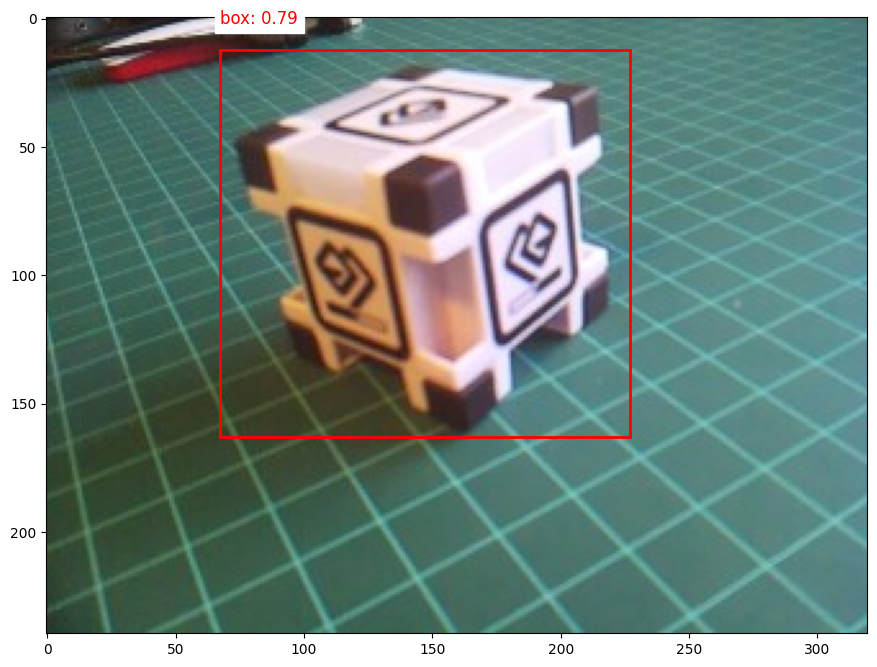

In [24]:
img_path = "./images/1_box.jpg"
detect_objects(img_path, conf=0.5)

In [31]:
ls ./images/

1_box.jpg          2-wheel.jpg        cat_dog.jpeg     office.jpeg
2_box-1_wheel.jpg  3_box-4_wheel.jpg  cats_dogs.jpg    ship_2.jpg
2_box_2_wheel.jpg  beagles.jpg        home-office.jpg
2-box.jpg          beatch.jpg         man_cat_dog.jpg


Inference time: 589.2ms


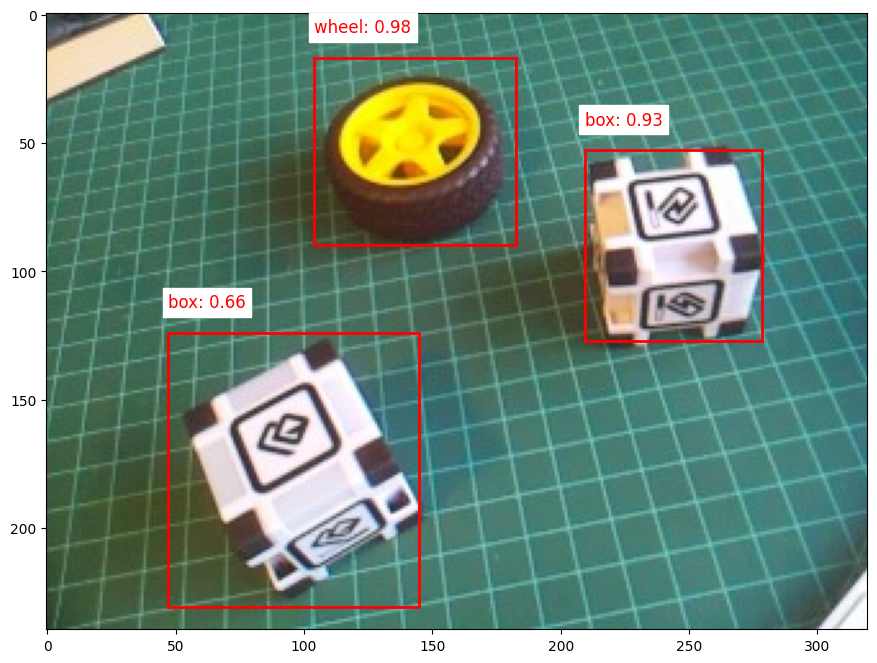

In [26]:
img_path = "./images/2_box-1_wheel.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 586.6ms


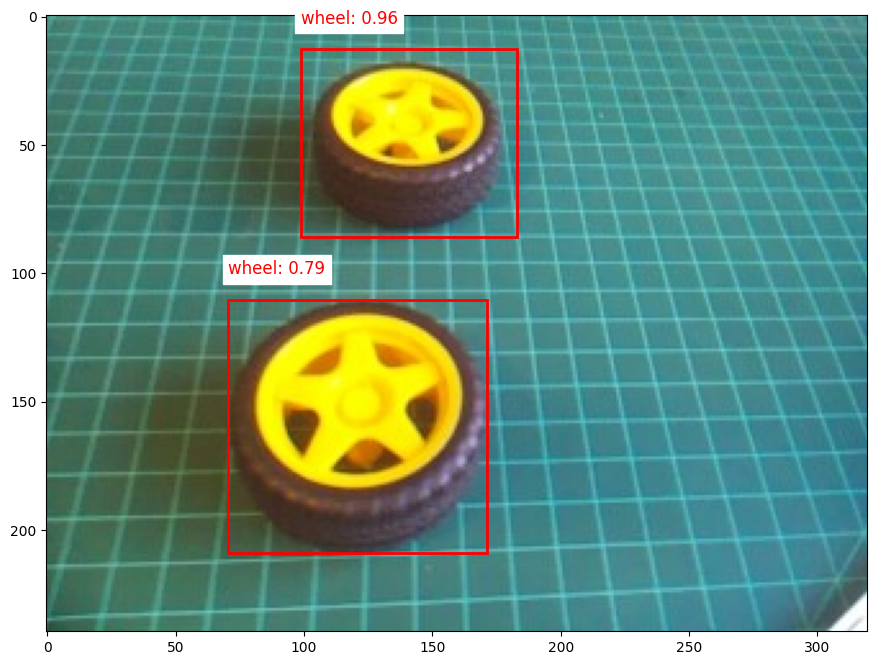

In [27]:
img_path = "./images/2-wheel.jpg"
detect_objects(img_path, conf=0.5)

Inference time: 614.6ms


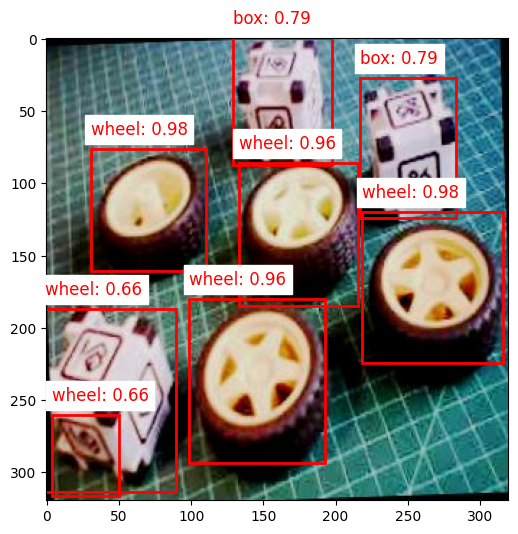

In [33]:
img_path = "./images/3_box-4_wheel.jpg"
detect_objects(img_path, conf=0.3)

In [28]:
def non_max_suppression(boxes, scores, threshold):
    # Convert to corner coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= threshold)[0]
        order = order[inds + 1]

    return keep

In [29]:
def visualize_detections(image, boxes, classes, scores, labels, threshold, iou_threshold):
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    height, width = image_np.shape[:2]
    
    # Convert normalized coordinates to pixel coordinates
    boxes_pixel = boxes * np.array([height, width, height, width])
    
    # Apply NMS
    keep = non_max_suppression(boxes_pixel, scores, iou_threshold)
    
    # Set the figure size to 12x8 inches
    fig, ax = plt.subplots(1, figsize=(6, 6))

    ax.imshow(image_np)
    
    for i in keep:
        if scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            rect = patches.Rectangle((xmin * width, ymin * height),
                                     (xmax - xmin) * width,
                                     (ymax - ymin) * height,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            class_name = labels[int(classes[i])]
            ax.text(xmin * width, ymin * height - 10,
                    f'{class_name}: {scores[i]:.2f}', color='red',
                    fontsize=12, backgroundcolor='white')

    plt.show()

In [30]:
def detect_objects(img_path, conf=0.5, iou=0.5):
    orig_img = Image.open(img_path)
    scale, zero_point = input_details[0]['quantization']
    img = orig_img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_array = (img_array / scale + zero_point).clip(-128, 127).astype(np.int8)
    input_data = np.expand_dims(img_array, axis=0)
    
    # Inference on Raspi-Zero
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    end_time = time.time()
    inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
    print ("Inference time: {:.1f}ms".format(inference_time))
    
    # Extract the outputs
    boxes = interpreter.get_tensor(output_details[1]['index'])[0]  
    classes = interpreter.get_tensor(output_details[3]['index'])[0]  
    scores = interpreter.get_tensor(output_details[0]['index'])[0]        
    num_detections = int(interpreter.get_tensor(output_details[2]['index'])[0])

    visualize_detections(orig_img, boxes, classes, scores, labels, 
                         threshold=conf, 
                         iou_threshold=iou)
    

Inference time: 628.3ms


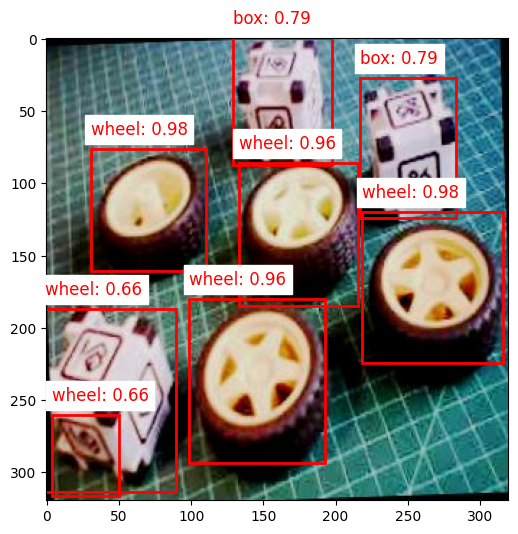

In [42]:
img_path = "./images/3_box-4_wheel.jpg"
detect_objects(img_path, conf=0.6,iou=0.5)

Inference time: 617.2ms


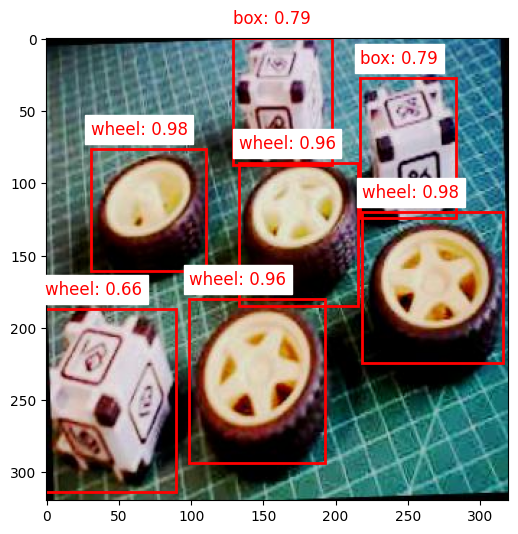

In [41]:
img_path = "./images/3_box-4_wheel.jpg"
detect_objects(img_path, conf=0.6,iou=0.05)

Inference time: 604.3ms


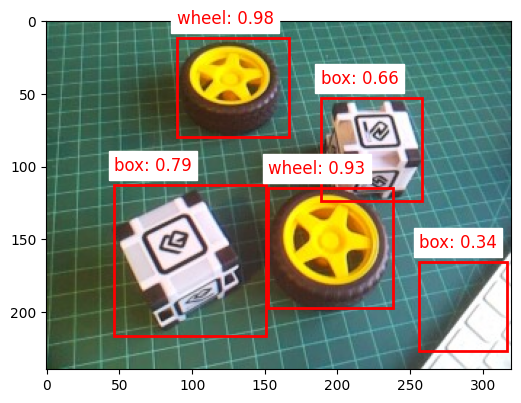

In [44]:
img_path = "./images/2_box_2_wheel.jpg"
detect_objects(img_path, conf=0.3,iou=0.05)

Inference time: 585.6ms


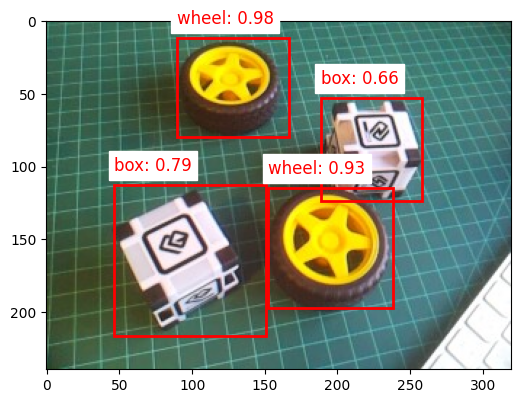

In [46]:
img_path = "./images/2_box_2_wheel.jpg"
detect_objects(img_path, conf=0.5,iou=0.05)